In [47]:
!jupyter_contrib_nbextensions --user

'jupyter_contrib_nbextensions' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso,SGDRegressor,LogisticRegression
from sklearn import svm,tree
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.model_selection import GridSearchCV

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("C:/Users/theo2/OneDrive/Documents/A4\Python for Data Analysis/PROJET FINAL/ObesityDataSet_raw_and_data_sinthetic.csv")

In [4]:
df=df.rename(columns = {"family_history_with_overweight": "genetic",
                          "FAVC": "high_calorific",
                          "FCVC": "vegetable",
                          "NCP": "frequence_meal",
                          "CAEC": "between_meal",
                          "CH2O": "water",
                          "SCC": "calories_monitoring",
                          "FAF": "physical_activity",
                          "TUE": "technology_time",
                          "CALC": "alcohol",
                          "MTRANS": "transportation",
                          "NObeyesdad": "obesity",
                          "SMOKE":"smoke",  
                         })

In [5]:
df['genetic'] = df['genetic'].map({'yes': 1, 'no': 0})
df['high_calorific'] = df['high_calorific'].map({'yes': 1, 'no': 0})
df['smoke'] = df['smoke'].map({'yes': 1, 'no': 0})
df['calories_monitoring'] = df['calories_monitoring'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['obesity'] = df['obesity'].map({'Insufficient_Weight': 0, 'Normal_Weight': 1,'Overweight_Level_I': 2, 'Overweight_Level_II': 3,'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})



In [68]:
#df.drop_duplicates(inplace=True) : dire dans le rapport pk on le fait pas

In [6]:
df.count()

Gender                 2111
Age                    2111
Height                 2111
Weight                 2111
genetic                2111
high_calorific         2111
vegetable              2111
frequence_meal         2111
between_meal           2111
smoke                  2111
water                  2111
calories_monitoring    2111
physical_activity      2111
technology_time        2111
alcohol                2111
transportation         2111
obesity                2111
dtype: int64

In [7]:
df

,Gender,Age,Height,Weight,genetic,high_calorific,vegetable,frequence_meal,between_meal,smoke,water,calories_monitoring,physical_activity,technology_time,alcohol,transportation,obesity
0,0,21.000000,1.620000,64.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,0.000000,1.000000,no,Public_Transportation,1
1,0,21.000000,1.520000,56.000000,1,0,3.0,3.0,Sometimes,1,3.000000,1,3.000000,0.000000,Sometimes,Public_Transportation,1
2,1,23.000000,1.800000,77.000000,1,0,2.0,3.0,Sometimes,0,2.000000,0,2.000000,1.000000,Frequently,Public_Transportation,1
3,1,27.000000,1.800000,87.000000,0,0,3.0,3.0,Sometimes,0,2.000000,0,2.000000,0.000000,Frequently,Walking,2
4,1,22.000000,1.780000,89.800000,0,0,2.0,1.0,Sometimes,0,2.000000,0,0.000000,0.000000,Sometimes,Public_Transportation,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,1.710730,131.408528,1,1,3.0,3.0,Sometimes,0,1.728139,0,1.676269,0.906247,Sometimes,Public_Transportation,6
2107,0,21.982942,1.748584,133.742943,1,1,3.0,3.0,Sometimes,0,2.005130,0,1.341390,0.599270,Sometimes,Public_Transportation,6
2108,0,22.524036,1.752206,133.689352,1,1,3.0,3.0,Sometimes,0,2.054193,0,1.414209,0.646288,Sometimes,Public_Transportation,6
2109,0,24.361936,1.739450,133.346641,1,1,3.0,3.0,Sometimes,0,2.852339,0,1.139107,0.586035,Sometimes,Public_Transportation,6


In [8]:
df=pd.get_dummies(df, columns=['between_meal', 'alcohol','transportation'])

In [37]:
df

,Gender,Age,Height,Weight,genetic,high_calorific,vegetable,frequence_meal,smoke,water,...,between_meal_no,alcohol_Always,alcohol_Frequently,alcohol_Sometimes,alcohol_no,transportation_Automobile,transportation_Bike,transportation_Motorbike,transportation_Public_Transportation,transportation_Walking
0,0,0.310928,0.023986,0.947589,0.014806,0.000000,0.029612,0.044418,0.000000,0.029612,...,0.0,0.0,0.000000,0.000000,0.014806,0.0,0.0,0.0,0.014806,0
1,0,0.348969,0.025259,0.930583,0.016618,0.000000,0.049853,0.049853,0.016618,0.049853,...,0.0,0.0,0.000000,0.016618,0.000000,0.0,0.0,0.0,0.016618,0
2,1,0.285560,0.022348,0.956006,0.012416,0.000000,0.024831,0.037247,0.000000,0.024831,...,0.0,0.0,0.012416,0.000000,0.000000,0.0,0.0,0.0,0.012416,0
3,1,0.295843,0.019723,0.953271,0.000000,0.000000,0.032871,0.032871,0.000000,0.021914,...,0.0,0.0,0.010957,0.000000,0.000000,0.0,0.0,0.0,0.000000,1
4,1,0.237741,0.019235,0.970416,0.000000,0.000000,0.021613,0.010806,0.000000,0.021613,...,0.0,0.0,0.000000,0.010806,0.000000,0.0,0.0,0.0,0.010806,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.157490,0.012844,0.986591,0.007508,0.007508,0.022523,0.022523,0.000000,0.012975,...,0.0,0.0,0.000000,0.007508,0.000000,0.0,0.0,0.0,0.007508,0
2107,0,0.162049,0.012890,0.985895,0.007372,0.007372,0.022115,0.022115,0.000000,0.014781,...,0.0,0.0,0.000000,0.007372,0.000000,0.0,0.0,0.0,0.007372,0
2108,0,0.165991,0.012913,0.985226,0.007370,0.007370,0.022109,0.022109,0.000000,0.015138,...,0.0,0.0,0.000000,0.007370,0.000000,0.0,0.0,0.0,0.007370,0
2109,0,0.179547,0.012820,0.982761,0.007370,0.007370,0.022110,0.022110,0.000000,0.021022,...,0.0,0.0,0.000000,0.007370,0.000000,0.0,0.0,0.0,0.007370,0


In [9]:
from sklearn.preprocessing import Normalizer
test_df=df.obesity
df=df.drop('obesity',axis=1)
df.iloc[:,1:-1] = Normalizer().fit_transform(df.iloc[:,1:-1])
df

,Gender,Age,Height,Weight,genetic,high_calorific,vegetable,frequence_meal,smoke,water,...,between_meal_no,alcohol_Always,alcohol_Frequently,alcohol_Sometimes,alcohol_no,transportation_Automobile,transportation_Bike,transportation_Motorbike,transportation_Public_Transportation,transportation_Walking
0,0,0.310928,0.023986,0.947589,0.014806,0.000000,0.029612,0.044418,0.000000,0.029612,...,0.0,0.0,0.000000,0.000000,0.014806,0.0,0.0,0.0,0.014806,0
1,0,0.348969,0.025259,0.930583,0.016618,0.000000,0.049853,0.049853,0.016618,0.049853,...,0.0,0.0,0.000000,0.016618,0.000000,0.0,0.0,0.0,0.016618,0
2,1,0.285560,0.022348,0.956006,0.012416,0.000000,0.024831,0.037247,0.000000,0.024831,...,0.0,0.0,0.012416,0.000000,0.000000,0.0,0.0,0.0,0.012416,0
3,1,0.295843,0.019723,0.953271,0.000000,0.000000,0.032871,0.032871,0.000000,0.021914,...,0.0,0.0,0.010957,0.000000,0.000000,0.0,0.0,0.0,0.000000,1
4,1,0.237741,0.019235,0.970416,0.000000,0.000000,0.021613,0.010806,0.000000,0.021613,...,0.0,0.0,0.000000,0.010806,0.000000,0.0,0.0,0.0,0.010806,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.157490,0.012844,0.986591,0.007508,0.007508,0.022523,0.022523,0.000000,0.012975,...,0.0,0.0,0.000000,0.007508,0.000000,0.0,0.0,0.0,0.007508,0
2107,0,0.162049,0.012890,0.985895,0.007372,0.007372,0.022115,0.022115,0.000000,0.014781,...,0.0,0.0,0.000000,0.007372,0.000000,0.0,0.0,0.0,0.007372,0
2108,0,0.165991,0.012913,0.985226,0.007370,0.007370,0.022109,0.022109,0.000000,0.015138,...,0.0,0.0,0.000000,0.007370,0.000000,0.0,0.0,0.0,0.007370,0
2109,0,0.179547,0.012820,0.982761,0.007370,0.007370,0.022110,0.022110,0.000000,0.021022,...,0.0,0.0,0.000000,0.007370,0.000000,0.0,0.0,0.0,0.007370,0


In [10]:
test_df=test_df.to_frame()

In [31]:
from sklearn.model_selection import train_test_split

X=df.drop(['smoke','calories_monitoring'],axis=1)
y=test_df.obesity  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [32]:
X_train

,Gender,Age,Height,Weight,genetic,high_calorific,vegetable,frequence_meal,water,physical_activity,...,between_meal_no,alcohol_Always,alcohol_Frequently,alcohol_Sometimes,alcohol_no,transportation_Automobile,transportation_Bike,transportation_Motorbike,transportation_Public_Transportation,transportation_Walking
28,1,0.241728,0.022264,0.966913,0.012723,0.012723,0.038168,0.038168,0.025445,0.038168,...,0.0,0.0,0.0,0.012723,0.0,0.000000,0.0,0.0,0.012723,0
1837,0,0.149134,0.012911,0.987944,0.007121,0.007121,0.021364,0.021364,0.018811,0.003429,...,0.0,0.0,0.0,0.007121,0.0,0.000000,0.0,0.0,0.007121,0
682,0,0.354453,0.031529,0.930474,0.000000,0.018648,0.022619,0.059807,0.019202,0.037297,...,0.0,0.0,0.0,0.018648,0.0,0.000000,0.0,0.0,0.018648,0
981,1,0.307034,0.017923,0.950691,0.009368,0.009368,0.018736,0.019775,0.020381,0.009368,...,0.0,0.0,0.0,0.009368,0.0,0.000000,0.0,0.0,0.000000,1
1804,0,0.239126,0.014722,0.969822,0.009197,0.009197,0.027591,0.027591,0.009486,0.000000,...,0.0,0.0,0.0,0.009197,0.0,0.000000,0.0,0.0,0.009197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,1,0.258425,0.026847,0.961916,0.014357,0.014357,0.043071,0.043071,0.043071,0.014357,...,0.0,0.0,0.0,0.014357,0.0,0.014357,0.0,0.0,0.000000,0
2041,0,0.235862,0.015559,0.970530,0.009260,0.009260,0.027780,0.027780,0.013178,0.001833,...,0.0,0.0,0.0,0.009260,0.0,0.000000,0.0,0.0,0.009260,0
33,1,0.397294,0.018235,0.916831,0.000000,0.000000,0.020374,0.010187,0.020374,0.000000,...,0.0,0.0,0.0,0.010187,0.0,0.000000,0.0,0.0,0.010187,0
313,1,0.289479,0.028267,0.953579,0.017028,0.017028,0.017028,0.051085,0.034056,0.017028,...,0.0,0.0,0.0,0.017028,0.0,0.000000,0.0,0.0,0.017028,0


In [33]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


In [34]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.944794952681388


In [35]:
def Test_algo_Obesity(models, labels,train_x,test_x,train_y,test_y):
    dict_train_score={}
    dict_test_score={}
    for k in range(len(models)):
        model=models[k]
        model.fit(train_x,train_y)
        dict_train_score[labels[k]]=model.score(train_x,train_y)
        dict_test_score[labels[k]]=model.score(test_x,test_y)
        print("Test {} score ={: 0.3f}".format(labels[k],dict_test_score[labels[k]]))
    print("\nbest Model for Obesity dataset is {} with test score :{: 0.3f}".format(max(dict_test_score, key=dict_test_score.get),dict_test_score[max(dict_test_score, key=dict_test_score.get)]))
    return max(dict_test_score, key=dict_test_score.get)

In [36]:
models_liste=[svm.SVC(),tree.DecisionTreeClassifier(),RandomForestClassifier(n_estimators=500),KNeighborsClassifier(),LogisticRegression()]
labels_liste=["SVM","Desicion tree","RandomForest","KNeighbors","LogisticRegression"]

In [37]:
Test_algo_Obesity(models_liste, labels_liste,X_train, X_test, y_train, y_test)

Test SVM score = 0.372
Test Desicion tree score = 0.905
Test RandomForest score = 0.940
Test KNeighbors score = 0.822
Test LogisticRegression score = 0.385

best Model for Obesity dataset is RandomForest with test score : 0.940


'RandomForest'

In [38]:

import numpy as np

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [39]:
importances

array([7.76658133e-02, 4.80709590e-02, 2.09903965e-01, 6.20252827e-02,
       6.52038694e-02, 9.42438899e-02, 5.06501565e-02, 7.71257770e-02,
       3.30322276e-02, 2.64130853e-02, 2.74506383e-02, 2.70109159e-03,
       1.20908540e-02, 6.11796276e-02, 2.79509111e-03, 0.00000000e+00,
       3.18673128e-03, 4.72526195e-02, 2.22483486e-02, 1.43628139e-02,
       2.02458097e-04, 1.47234078e-04, 5.99955886e-02, 2.05187750e-03])

In [40]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

In [41]:
X_train.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'genetic', 'high_calorific',
       'vegetable', 'frequence_meal', 'water', 'physical_activity',
       'technology_time', 'between_meal_Always', 'between_meal_Frequently',
       'between_meal_Sometimes', 'between_meal_no', 'alcohol_Always',
       'alcohol_Frequently', 'alcohol_Sometimes', 'alcohol_no',
       'transportation_Automobile', 'transportation_Bike',
       'transportation_Motorbike', 'transportation_Public_Transportation',
       'transportation_Walking'],
      dtype='object')

In [42]:
import matplotlib.pyplot as plt

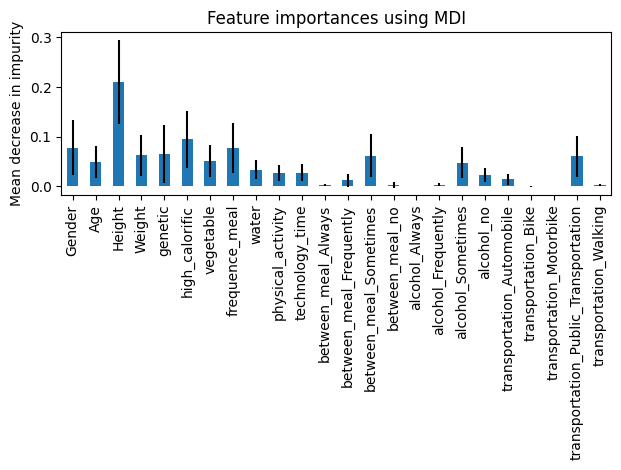

In [43]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that smoke, calories_monitoring have almost no impact, that's why we remove them : thus, we can ask fewer questions to the sample

In [60]:
df.alcohol_Always.value_counts()

0.000000    2110
0.014607       1
Name: alcohol_Always, dtype: int64

In [44]:
param_grid={"max_depth":[k for k in range(5)],"n_estimators":[k for k in range(1,10)],"criterion":["gini","entropy","log_loss"]}
grid=GridSearchCV(RandomForestClassifier(),param_grid)
grid.fit(X_train,y_train)
print('grid params best model',grid.best_params_)
print('grid score best model',grid.best_score_)
best_model=grid.best_estimator_
print('test score best model', best_model.score(X_test,y_test))

grid params best model {'criterion': 'log_loss', 'max_depth': 4, 'n_estimators': 9}
grid score best model 0.8124393037104902
test score best model 0.7933753943217665


In [20]:
df.groupby('NObeyesdad').mean()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
NObeyesdad,,,,,,,,
Insufficient_Weight,19.783237,1.691117,49.906330,2.480788,2.914403,1.871281,1.250131,0.839459
Normal_Weight,21.738676,1.676585,62.155052,2.334495,2.738676,1.850174,1.247387,0.675958
Obesity_Type_I,25.884941,1.693804,92.870198,2.186050,2.431862,2.112218,0.986748,0.676743
Obesity_Type_II,28.233785,1.771795,115.305311,2.391284,2.744555,1.877658,0.971857,0.515186
Obesity_Type_III,23.495554,1.687559,120.941114,3.000000,3.000000,2.208493,0.664817,0.604623
Overweight_Level_I,23.417674,1.687836,74.266828,2.264631,2.504218,2.058725,1.056796,0.612992
Overweight_Level_II,26.996981,1.703748,82.085271,2.260578,2.495529,2.025133,0.958072,0.697275
